# cnn with resnet-50
---


In [2]:

import torch as tc
import torchvision as tcv
from torchvision import transforms, datasets
import torch.utils as utils
from torch.utils.data import DataLoader
from torchvision import models
import tqdm
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import json
device = tc.device('cuda')
log = {
    "train_avrloss":[],
    "test_avrloss":[],
    "test_confusion_mat":[],
}

In [25]:
# Load dataset and spilt into trainset and testset.

def load_pic_sets(
    input_path:str,
):
    trans = transforms.Compose([
        transforms.Resize([900, 900]),
        transforms.RandomResizedCrop(size=(300, 300), scale=(0.8,1.2)),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        #transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        #transforms.Lambda(lambda crops: print(crops)),
    ])
    sets = datasets.ImageFolder(input_path, transform=trans)
    print("classes with index:",sets.class_to_idx)
    #dataloader = DataLoader(sets, batch_size=16, shuffle=True)
    train_set, test_set = utils.data.random_split(sets, [0.9, 0.1], generator=tc.Generator().manual_seed(0))
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=15)
    test_loader =  DataLoader(test_set, batch_size=1, shuffle=True, num_workers=15) 
    return train_loader, test_loader
show_tensor_pic = transforms.ToPILImage()
train_dataloader, test_dataloader = load_pic_sets('./raw_norm_spilt_data')

classes with index: {'DP590': 0, 'DP600': 1, 'DP780': 2, 'DP980': 3}


In [16]:
# Load resnet from scratch or from file

resnet = models.resnet50(weights=None) #pretrained=True 加载模型以及训练过的参数
infe = resnet.fc.in_features
resnet.fc = tc.nn.Sequential(tc.nn.Linear(infe, 4), tc.nn.LeakyReLU())
#print(resnet)
optimizer = tc.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
loss_fn = tc.nn.SmoothL1Loss()

# from file.
#resnet = tc.load("./good_res50_i100x100_o4_500epoch.tcm")


/tmp/ipykernel_2579527/1885096656.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = tc.load("./good_res50_i100x100_o4_500epoch.tcm")


In [4]:
####
#### Train
####
resnet=resnet.to(device)
epoch=400
for i in range(epoch):
    print('epoch', i,'----------')
    resnet.train()
    # train one epoch in train_dataloader
    totaloss, total = 0, 0
    tqdm_item = tqdm.tqdm(train_dataloader)
    for k, v in tqdm_item:
        v = tc.eye(4)[v]
        v = v.to(device)
        k = k.to(device)
        o = resnet.forward(k)
        loss = loss_fn(v, o)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totaloss += float(loss)
        total += 1
        tqdm_item.set_postfix(loss=float(loss), avrloss=totaloss/total)
    log['train_avrloss'] += [totaloss/total]
    # test one epoch in test_dataloader
    resnet.eval()
    tqdm_item = tqdm.tqdm(test_dataloader)
    accurate, total = 0, 0
    totaloss = 0.0
    confusion = tc.zeros(4,4)
    for k, v in tqdm_item:
        v = tc.eye(4)[v]
        v = v.to(device)
        k = k.to(device)
        o = resnet.forward(k)
        argo = tc.argmax(o, dim=1)
        argv = tc.argmax(v, dim=1)
        loss = loss_fn(v, o)
        totaloss += float(loss)
        confusion[int(argv)][int(argo)] += 1
        if argo==argv: accurate += 1
        total += 1
        tqdm_item.set_postfix(loss=float(loss), avrloss=totaloss/total)
    print('accuracy on test set:', accurate/total)
    print('test set confusion mat:\n', confusion)
    log['test_avrloss'] += [totaloss/total]
    log['test_confusion_mat'] += [confusion.numpy().tolist()]
        

epoch 0 ----------


100%|██████████| 1425/1425 [00:45<00:00, 31.12it/s, avrloss=0.07, loss=0.138]     

accuracy on test set: 0.6126315789473684
test set confusion mat: tensor([[306.,  35.,  60.,   0.],
        [ 18., 217.,  93.,   0.],
        [ 15.,  42., 350.,   0.],
        [  7.,  88., 194.,   0.]])


In [5]:
# Save my module.
tc.save(resnet, "good_res50_o4_400epoch.tcm")
print('saving at good_res50_o4_400epoch.tcm')
with open('./test.txt', 'w', encoding='utf-8') as f:
    f.write(str(log))

saving at good_res101_i100x100_o4_200epoch.tcm


In [ ]:

# test module. depreciated 
"""
_,test_dataloader = load_pic_sets("./raw_norm_spilt_data")
resnet50=resnet
resnet50.eval()
confusion = tc.zeros(4,4)
tqdm_item = tqdm.tqdm(test_dataloader)
accurate, total = 0, 0
for k, v in tqdm_item:
    v = tc.eye(4)[v]
    v = v.to(device)
    k = k.to(device)
    o = resnet50.forward(k)
    argo = tc.argmax(o, dim=1)
    argv = tc.argmax(v, dim=1)
    confusion[int(argv)][int(argo)] += 1
    #print(argo, argv)
    if argo==argv: accurate += 1
    total += 1
print('accuracy on test set:', accurate/total)
print('confusion matrix:', confusion)
"""


dict_keys(['train_avrloss', 'test_avrloss', 'test_confusion_mat'])


/var/folders/f9/w4lr4qhs0rx946f35ld4zk3m0000gn/T/ipykernel_64404/2137370859.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


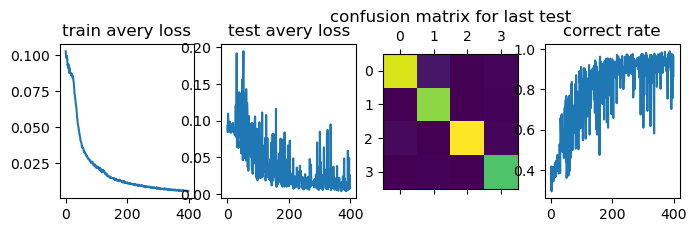

In [13]:
# 显示训练结果
#print(f"epoch = {epoch}")


with open("./tmp/test.txt", 'r', encoding='UTF-8') as f:
    log_str = f.read()
log = eval(log_str)
print(log.keys())
epoch = len(log['train_avrloss'])
fig, ax = plt.subplots(1, 4, figsize=(8,2))
x = np.arange(0, epoch)
ax[0].set_title('train avery loss')
ax[0].plot(x, log['train_avrloss'])
ax[1].set_title('test avery loss')
ax[1].plot(x, log['test_avrloss'])
ax[2].set_title('confusion matrix for last test')
ax[2].matshow(log['test_confusion_mat'][-1])
def conmats2corate(conmats:list):
    conmats = np.array(conmats)
    ans = [0 for i in range(len(conmats))]
    for i in range(len(conmats)):
        ans[i] = np.diag(conmats[i]).sum()/conmats[i].sum()
    return ans
t = conmats2corate(log['test_confusion_mat'])
ax[3].set_title('correct rate')
ax[3].plot(x, t)
fig.show()
